In [1]:
import numpy as np
import pandas as pd
import torch
import transformers
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
import torch

In [3]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self,df,out,max_len=96):
        
        self.df = df
        self.out = out
        self.max_len = max_len
        self.tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
        
    def __getitem__(self,index):
        data = {}
        row = self.df.iloc[index]
        ids,masks,labels = self.get_input_data(row)
        data['ids'] = torch.tensor(ids)
        data['masks'] = masks
        data['labels'] = torch.tensor(self.out.iloc[index].values[0],dtype=torch.float32)
        return data
    
    def __len__(self):
        return len(self.df)
    
    def get_input_data(self,row):
        ids = self.tokenizer.encode(row[0],add_special_tokens=True)
        pad_len = self.max_len - len(ids)
        if pad_len > 0 :
            ids += [0]*pad_len
        ids = torch.tensor(ids)    
        masks = torch.where(ids != 0 , torch.tensor(1),torch.tensor(0))
        return ids,masks,self.out.iloc[0].values

In [4]:
df= pd.read_csv("C:\\Users\\HP\\Downloads\\train1.csv")
 

In [5]:
df1= pd.read_csv("C:\\Users\\HP\\Downloads\\test1.csv")

In [6]:
print(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649999 entries, 0 to 649998
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   rating     649999 non-null  int64 
 1   sentences  649999 non-null  object
dtypes: int64(1), object(1)
memory usage: 9.9+ MB
None


,rating,sentences
0,2,"Unfortunately, the frustration of being Dr. Go..."
1,4,Been going to Dr. Goldberg for over 10 years. ...
2,4,Got a letter in the mail last week that said D...
3,1,I don't know what Dr. Goldberg was like before...
4,5,Top notch doctor in a top notch practice. Can'...


In [7]:
print(df1.info())
display(df1.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49999 entries, 0 to 49998
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   rating     49999 non-null  int64 
 1   sentences  49999 non-null  object
dtypes: int64(1), object(1)
memory usage: 781.4+ KB
None


,rating,sentences
0,1,Don't waste your time. We had two different p...
1,1,All I can say is the worst! We were the only 2...
2,1,I have been to this restaurant twice and was d...
3,1,Food was NOT GOOD at all! My husband & I ate h...
4,3,This is a tiny Starbucks and it locations like...


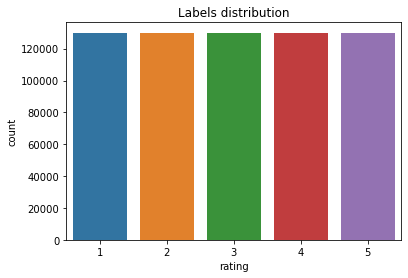

In [8]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

sns.countplot(df['rating']);
plt.title('Labels distribution');

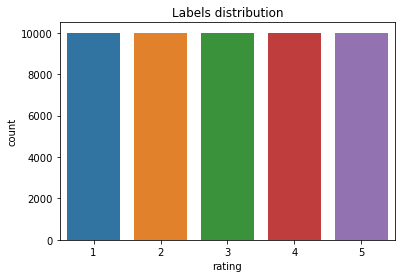

In [9]:
sns.countplot(df1['rating']);
plt.title('Labels distribution');

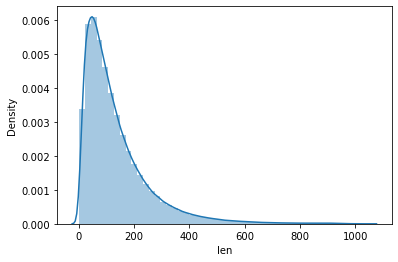

In [10]:
df['len'] = df['sentences'].apply(lambda x: len(x.split()))
sns.distplot(df['len']);

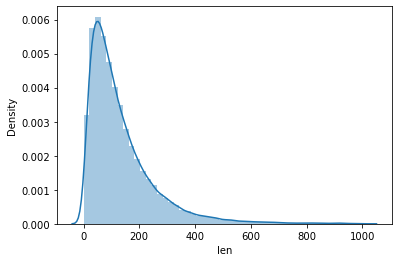

In [11]:
df1['len'] = df1['sentences'].apply(lambda x: len(x.split()))
sns.distplot(df1['len']);

Negative mean length: 151.47
Positive mean length: 152.02
Mean Difference: -0.55


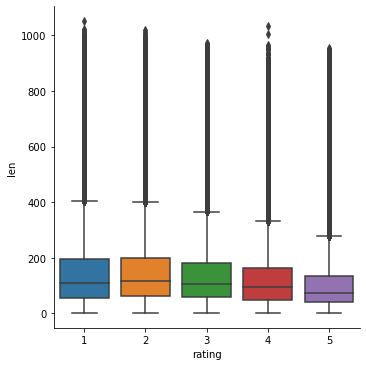

In [12]:
neg_mean_len = df.groupby('rating')['len'].mean().values[0]
pos_mean_len = df.groupby('rating')['len'].mean().values[1]

print(f"Negative mean length: {neg_mean_len:.2f}")
print(f"Positive mean length: {pos_mean_len:.2f}")
print(f"Mean Difference: {neg_mean_len-pos_mean_len:.2f}")
ax = sns.catplot(x='rating', y='len', data=df, kind='box')

Negative mean length: 150.83
Positive mean length: 152.03
Mean Difference: -1.19


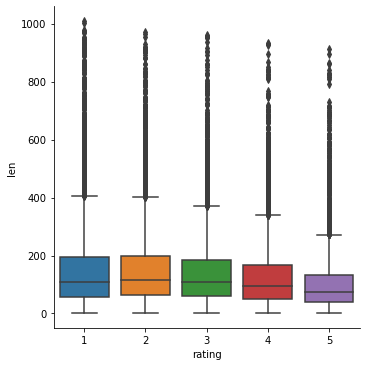

In [13]:
neg_mean_len = df1.groupby('rating')['len'].mean().values[0]
pos_mean_len = df1.groupby('rating')['len'].mean().values[1]

print(f"Negative mean length: {neg_mean_len:.2f}")
print(f"Positive mean length: {pos_mean_len:.2f}")
print(f"Mean Difference: {neg_mean_len-pos_mean_len:.2f}")
ax = sns.catplot(x='rating', y='len', data=df1, kind='box')

In [14]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self,df,out,max_len=96):
        
        self.df = df
        self.out = out
        self.max_len = max_len
        self.tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
        
    def __getitem__(self,index):
        data = {}
        row = self.df.iloc[index]
        ids,masks,labels = self.get_input_data(row)
        data['ids'] = torch.tensor(ids)
        data['masks'] = masks
        data['labels'] = torch.tensor(self.out.iloc[index].values[0],dtype=torch.float32)
        return data
    
    def __len__(self):
        return len(self.df)
    
    def get_input_data(self,row):
        ids = self.tokenizer.encode(row[0],add_special_tokens=True)
        pad_len = self.max_len - len(ids)
        if pad_len > 0 :
            ids += [0]*pad_len
        ids = torch.tensor(ids)    
        masks = torch.where(ids != 0 , torch.tensor(1),torch.tensor(0))
        return ids,masks,self.out.iloc[0].values

In [15]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc.item()

In [16]:
class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        config = transformers.DistilBertConfig.from_pretrained('distilbert-base-uncased')
        self.distilBert = transformers.DistilBertModel.from_pretrained('distilbert-base-uncased',config=config)
        self.fc0 = nn.Linear(768,512)
        self.d0 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(512,256)
        self.d1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256,1)
        nn.init.normal_(self.fc0.weight,std= 0.1)
        nn.init.normal_(self.fc0.bias ,0.)
        nn.init.normal_(self.fc1.weight,std =0.1)
        nn.init.normal_(self.fc1.bias, 0.)
        nn.init.normal_(self.fc2.weight,std=0.1)
        nn.init.normal_(self.fc2.bias , 0.)
    def forward(self,input_ids,attention_mask):
        hid= self.distilBert(input_ids,attention_mask = attention_mask)
        hid= hid[0][:,0]
        x = self.fc0(hid)
        x = F.relu(x)
        x = self.d0(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.d1(x)
        return self.fc2(x)

In [17]:
def get_iterator(data, batch_size=32, max_length=30, shuffle=True, num_workers=4, pin_memory=True):
    cap, vocab = data
    return torch.utils.data.DataLoader(
        cap,
        batch_size=batch_size, shuffle=shuffle,
        collate_fn=create_batches(vocab, max_length),
        num_workers=num_workers, pin_memory=pin_memory)

In [18]:
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, Normalize

import timm

import argus
from argus.callbacks import MonitorCheckpoint, EarlyStopping, ReduceLROnPlateau


def get_data_loaders(batch_size):
    data_transform = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])
    train_mnist_dataset = MNIST(download=True, root="mnist_data",
                                transform=data_transform, train=True)
    val_mnist_dataset = MNIST(download=False, root="mnist_data",
                              transform=data_transform, train=False)
    train_loader = DataLoader(train_mnist_dataset,
                              batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_mnist_dataset,
                            batch_size=batch_size * 2, shuffle=False)
    return train_loader, val_loader

            


In [19]:
def test(sentence):
    tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    ids = tokenizer.encode(sentence,add_special_tokens=True)
    padded = ids + [0]*(80 - len(ids))
    padded = torch.tensor(padded,dtype=torch.int64).unsqueeze(0)
    masks = torch.where(padded != 0 , torch.tensor(1), torch.tensor(0)).cuda()
    padded = padded.cuda()
    model.eval()
    output = model(padded,masks)
    return torch.round(F.sigmoid(output)).item()

In [20]:
import torch
print(torch.rand(5, 3))

tensor([[0.1432, 0.0302, 0.3760],
        [0.4062, 0.9000, 0.2895],
        [0.2297, 0.0225, 0.8774],
        [0.5430, 0.4036, 0.9691],
        [0.1013, 0.6317, 0.1331]])


In [21]:
neg_array = df[df['rating']==0]['len'].values
pos_array = df[df['rating']==1]['len'].values
mean_diff = neg_mean_len - pos_mean_len


In [22]:
def permutation_sample(data1, data2):
    # Permute the concatenated array: permuted_data
    data = np.concatenate((data1,data2))
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

In [23]:
def draw_perm_reps(data_1, data_2, size=1):

    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)

        # Compute the test statistic
        perm_replicates[i] = np.mean(perm_sample_1) - np.mean(perm_sample_2)

    return perm_replicates

In [24]:
perm_replicates = draw_perm_reps(neg_array, pos_array,
                                 size=10000)

# Compute p-value: p
p = np.sum(perm_replicates >= mean_diff) / len(perm_replicates)

print(f'p-value = {p}')

p-value = 0.0
